In [6]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
import numpy as np

import pickle

import sys
sys.path.append("../../../neuroprob")


import neuroprob as mdl
from neuroprob import utils

from tqdm.notebook import tqdm

dev = utils.pytorch.get_device()

plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.7.1+cu101
Using device: cuda:0


### Load data

In [19]:
### Real data ###
name = 'hc5_15'

sample_bin, track_samples, x_t, y_t, s_t, dir_t, hd_t, eeg_t, theta_t, \
    pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, isolation_dist, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/datasets/{}.p'.format(name), 'rb')) # hc5_15

arena_height = top_y - bottom_y
arena_width = right_x - left_x

max_speed = s_t.max()

In [3]:
name = 'hc2_ec013.527'
#name = 'hc2_ec015.041'

beh_sample_bin, x_t, y_t, hd_t, eeg_t, \
    units, sample_bin, track_samples, sep_t_spike, \
    refract_viol = pickle.load(open('../data/datasets/{}.p'.format(name), 'rb'))

sample_bin, resamples, spktrain, behav_t = neural_utils.BinTrain(20, sample_bin, [sep_t_spike[u] for u in range(units)], track_samples, 
                                          (x_t, y_t, hd_t), average_behav=False)
inval_ind, inval_size = tools.TrueIslands(behav_t[0] == -1.0)
assert len(inval_size) == 2

spktrain = spktrain[:, inval_size[0]:-inval_size[1]]
x_t = behav_t[0][inval_size[0]:-inval_size[1]]
y_t = behav_t[1][inval_size[0]:-inval_size[1]]
hd_t = behav_t[2][inval_size[0]:-inval_size[1]]
#track_samples = resamples - inval_size.sum()

sep_t_spike = []
for k in range(units):
    sep_t_spike.append(neural_utils.BinToTrain(spktrain[k]))
    
    
arena_height = 120.
arena_width = 120.

right_x = x_t.max()
left_x = x_t.max()-arena_width
top_y = y_t.max()
bottom_y = y_t.max()-arena_height

ValueError: too many values to unpack (expected 10)

In [ ]:
vx_t = (x_t[1:]-x_t[:-1])*39.06
vy_t = (y_t[1:]-y_t[:-1])*39.06
s_t = np.sqrt(vx_t**2 + vy_t**2)

In [7]:
print(len(eeg_t)*1.250)
print(track_samples)
print(resamples)

4746683.75
3797347


NameError: name 'resamples' is not defined

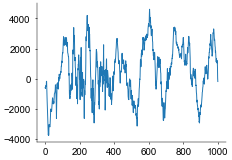

In [22]:
plt.plot(eeg_t[:1000])
np.savez_compressed('./checkpoint/{}_eeg'.format(name), eeg_t=eeg_t)

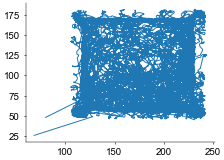

In [29]:
plt.plot(x_t, y_t)

### Select units

In [23]:
# binning of covariates and analysis
bins_hd = 60
bins_dir = 8
bins_s = 100
bins_x = 30
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 30

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)
#bin_s = np.linspace(0, max_speed+1e-3, bins_s+1)
#bin_dir = np.linspace(0, 2*np.pi+1e-3, bins_dir+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

corr_t_spikes = utils.neural.IPP_model(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), sep_t_spike)
sp_MI, sp_prob, sp_rate = utils.neural.spike_var_MI(sample_bin, (x_t, y_t), (bin_x, bin_y), corr_t_spikes)

hd_MI, hd_prob, hd_rate = utils.neural.spike_var_MI(sample_bin, (hd_t,), (bin_hd,), sep_t_spike)
#s_MI, s_prob, s_rate = neural_utils.spike_var_MI(sample_bin, (s_t,), (bin_s,), sep_t_spike)
#dir_MI, dir_prob, dir_rate = neural_utils.spike_var_MI(sample_bin, (dir_t,), (bin_dir,), sep_t_spike)

sm_size = 5
sm_filter = np.ones((sm_size, sm_size)) / sm_size**2
smth_rate = utils.neural.smooth_hist(sp_rate, sm_filter, ['repeat', 'repeat'], dev='cpu')
coherence, sparsity = utils.neural.geometric_tuning(sp_rate, smth_rate, sp_prob)



ISI, LV = utils.neural.compute_LV(sample_bin, sep_t_spike)

TypeError: spike_var_MI() takes 2 positional arguments but 4 were given

In [37]:
if name == 'hc5_15':
    criterion = {'isolation': 0.3, 'refractory': 2.0, 'coherence': 0.5, 'sparsity': 0.1}#, 'coherence': 0.5, 'sparsity': 0.5}
elif name == 'hc5_13':
    criterion = {'isolation': 0.3, 'refractory': 2.0, 'coherence': 0.3, 'sparsity': 0.1}#'coherence': 0.4, 'sparsity': 0.4}
elif name == 'hc2_ec013.527':
    criterion = {'refractory': 2.0}#, 'coherence': 0.3, 'sparsity': 0.6}
elif name == 'hc2_ec013.528':
    criterion = {'refractory': 2.0}#, 'coherence': 0.3, 'sparsity': 0.6}
elif name == 'hc2_ec015.041':
    criterion = {'refractory': 2.0}
else:
    raise ValueError

unit_used = []
for u in range(units):
    if ('spatial_rate' in criterion and sp_sess_rate[u].max() < criterion['spatial_rate']) or \
       ('spatial_info' in criterion and sp_MI[u] < criterion['spatial_info']) or \
       ('coherence' in criterion and coherence[u] < criterion['coherence']) or \
       ('isolation' in criterion and isolation_dist[u] < criterion['isolation']) or \
       ('refractory' in criterion and refract_viol[u] > criterion['refractory']) or \
       ('burst' in criterion and LV[u] < criterion['burst']) or \
       ('sparsity' in criterion and sparsity[u] < criterion['sparsity']):
        continue

    unit_used.append(u)
    
units_used = len(unit_used)
unit_used = np.array(unit_used)
print(unit_used)
print(units_used)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
31


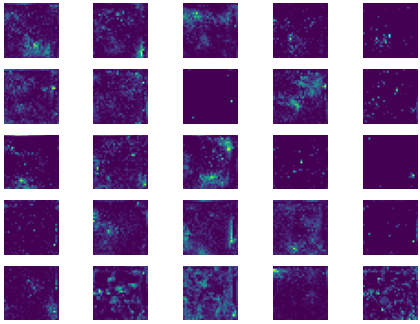

In [39]:
fig = plt.figure(figsize=(8, 6))
nrows = 5
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for nr in range(nrows):
    for nc in range(ncols):
        nnn = nr*ncols + nc
        _, ax, im = tools.draw_2d(np.transpose(sp_rate[unit_used[nnn]+5]), origin='lower', aspect='equal', 
                                cmap='viridis', vmax=sp_rate[unit_used[nnn]+5].max(), figax=(fig, axes[nnn]))
        tools.decorate_ax(ax, spines=[False, False, False, False])

In [25]:
spktrain.sum(-1)

array([6.7000e+01, 1.9100e+02, 6.1910e+03, 9.6900e+02, 5.3500e+02,
       5.0270e+03, 2.9750e+03, 5.6040e+03, 3.8300e+02, 8.9000e+01,
       4.8000e+03, 2.7250e+03, 6.0000e+00, 4.8470e+03, 2.9500e+02,
       3.0770e+03, 2.8180e+03, 6.8910e+03, 1.2100e+02, 1.5000e+01,
       8.1800e+02, 3.5830e+03, 8.2600e+03, 5.7130e+03, 1.2700e+02,
       1.9020e+03, 1.3389e+04, 2.8945e+04, 4.8530e+03, 1.5870e+03,
       2.0700e+02])

In [45]:
arena = np.array([left_x, right_x, bottom_y, top_y])

bin_size = 1
tbin, resamples, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, 
                                                 [sep_t_spike[u] for u in unit_used], track_samples)
print(tbin)

0.001


In [46]:
np.savez_compressed('./checkpoint/{}'.format(name), arena=arena,
                    spktrain=rc_t, x_t=x_t, y_t=y_t, s_t=s_t, dir_t=dir_t, hd_t=hd_t, theta_t=theta_t)

NameError: name 'theta_t' is not defined